# Table of Contents
[1 - Load module & Data ](#ch1)  
[2 - Data 전처리](#ch2)  
[3 - Simple visualization](#ch3)
* [correlation](#CH3.1)
* [pair plot](#ch3.2)  

[4 - Ensembling & Stacking models](#ch4)
* [4.1 class for classifier](#ch4.1)
* [4.2 Out-of-Fold Predictions](#ch4.2)
* [4.3 Generating our Base First-Level Models](#ch4.3)
* [4.4 Feature Importance](#ch4.4)

[5 - Second-Level Predictions from the First-level Output](#ch5)
- [5.1 First-level output as new features](#ch5.1)
- [5.2 Correlation Heatmap of the Second Level Training set](#ch5.2)
- [XGBoost를 이용한 두번째 level의 학습 모델(XGB Parameter tuning과정 포함)](#ch5.3)  

[6 - Final Submission](#ch6)


<a id="ch1"></a>
# 1. Load libraries & Data

In [226]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [227]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [228]:
import warnings
warnings.filterwarnings('ignore')

In [229]:
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.svm import SVC


#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold

###  Data Load

In [230]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")
#rbind `
df_all = df_train.append(df_test, ignore_index=True)

In [231]:
from sklearn.preprocessing import LabelEncoder

<a id="ch2"></a>
# 2.Data 전처리
아래의 전처리 과정은 제 git_hub의 Titanic_EDA & simple_modeling의 정보를 바탕으로 작성하였습니다.

In [232]:
def preprocessd(data):
    #Embarked & Fare
    
    #결측치가 1등급이고 여자이니 1등급에서 성별로 가격이 차이가 났고 이상치가 있었으니 median 값으로 Fare 대체
    data.Fare.fillna(data.groupby(['Pclass','Sex'])['Fare'].transform('median'), inplace = True)
    # Pclass 별로 가장 많은 Embarked의 값으로 대체
    data.Embarked.fillna(data.groupby('Pclass')['Embarked'].transform(lambda x:x.value_counts().index[0]), inplace = True)
    
    #Age
    data['title']=data.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())

    newtitles={
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Mme":        "Mrs",
        "Mlle":       "Miss",
        "Ms":         "Mrs",
        "Mr" :        "Mr",
        "Mrs" :       "Mrs",
        "Miss" :      "Miss",
        "Master" :    "Master",
        "Lady" :      "Royalty"}

    data['title']=data.title.map(newtitles)
    data.Age.fillna(data.groupby(['Pclass','title','Parch', 'SibSp']).Age.transform('median'), inplace = True) #최대로 정보 활용
    data.Age.fillna(data.groupby(['title']).Age.transform('median'), inplace = True) #나머지는 title만 이용
    
    #Feature enginnering
    data['Family_Size']=0
    data['Family_Size']= data['Parch']+data['SibSp'] # family size
    data['Alone']=0
    data.loc[df_all.Family_Size==0,'Alone']=1 #Alone
    data['Kinder']=0
    data.loc[data.Age <= 6,'Kinder']=1 #Alon2
    # Age 의 경우는 1씩 증가한다 즉 단위가 1단위라고 생각 할 수 있지만 
    # Fare 의 경우는 단위가 1이라도 분포를 보면 단위가 확 커질때가 있다.(PClass2,3 에서 Pclass 1로 갈때)
    # 따라서 Age 는 동일한 단위의 길이(?)로 나누지만 Fatebin은 qcut을 사용한다.
    data['FareBin'] = pd.qcut(data['Fare'], 5)
    data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)
    
    # Label Encoding
    label = LabelEncoder()
    data['Sex_Code'] = label.fit_transform(data['Sex'])
    data['AgeBin_Code'] = label.fit_transform(data['AgeBin'])
    data['FareBin_Code'] = label.fit_transform(data['FareBin'])
    #data['Embarked_Code'] = label.fit_transform(data['Embarked']) #어떻게 할지
    #data['Title_Code'] = label.fit_transform(data['title'])
    
    data.drop(["Age", 'Name','Cabin', 'Fare', 'Parch','SibSp','Ticket','Sex','FareBin','AgeBin','Alone'], axis = 1, inplace = True)
    #data.drop('Embarked', axis = 1, inplace = True)
    data.title = data.title.astype(object)
    
    #one hot encoding
    data = pd.get_dummies(data)
    
    return  data[data.Survived.isnull()] ,data.dropna(subset = ['Survived'])

**Data split into train & test after preprocessing**

In [233]:
df_test,df_train = preprocessd(df_all)

Test_id = df_test.PassengerId
train_id = df_train.PassengerId
df_train.drop("PassengerId", axis = 1, inplace = True)
df_test.drop("PassengerId", axis = 1, inplace = True)

<a id="ch3"></a>
# 3. Simple Visualization

<a id = 'CH3.1'></a>
## 3.1 Pearson correlation heatmap

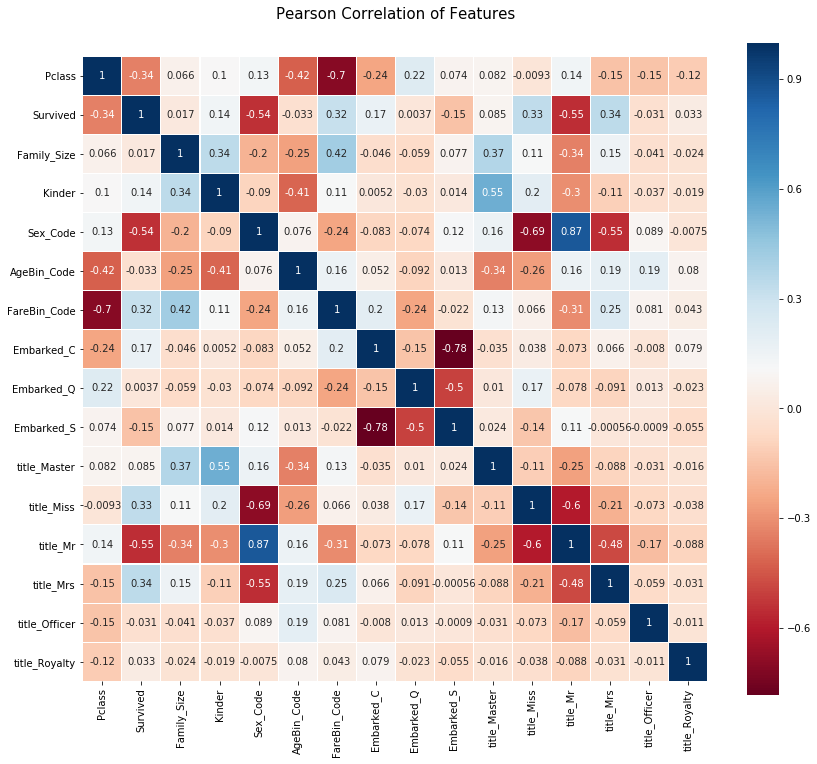

In [234]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

<a id = 'ch3.2'></a>
## 3.2 Pair plot

In [235]:
df_train.columns

Index(['Pclass', 'Survived', 'Family_Size', 'Kinder', 'Sex_Code',
       'AgeBin_Code', 'FareBin_Code', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_Officer',
       'title_Royalty'],
      dtype='object')

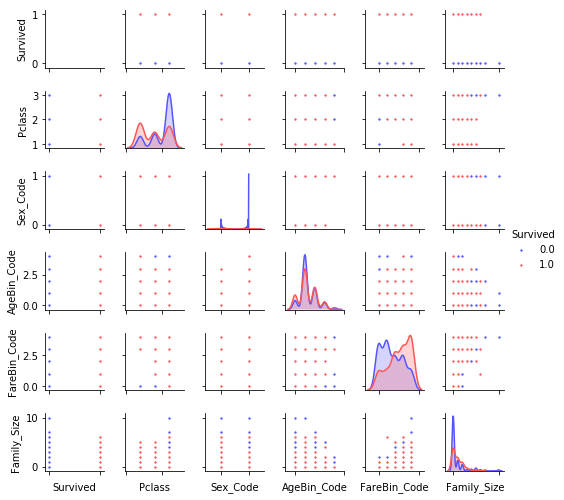

In [236]:
g = sns.pairplot(df_train[[u'Survived', u'Pclass', u'Sex_Code', u'AgeBin_Code', u'FareBin_Code',u'Family_Size']], hue='Survived', 
                 palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

<a id = 'ch4'></a>
# 4. Ensembling & Stacking models

<a id = 'ch4.1'></a>
## 4.1 class for classifier

In [237]:
# 나중에 유용하게 쓸 수있는 유용한 매개 변수
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
SEED = 1756 # 재현성을 위한 값
NFOLDS = 5 # out-of-fold prediction 위한 fold값 설정
kf = KFold(5, shuffle=True, random_state=0)

# Sklearn classifier 확장하기 위한 클래스
#**params https://stackoverflow.com/questions/36901/what-does-double-star-asterisk-and-star-asterisk-do-for-parameters
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params) 

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)       
# Class to extend XGboost classifer

#Naive bayesian
class SklearnHelper2(object):
    def __init__(self, clf, params=None):
        self.clf = clf() 

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)

<a id = 'ch4.2'></a>
## 4.2 Out-of-Fold Predictions  
k-fold cross validation(K = 5)

In [238]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test) # i번째 fold 의 예측값

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

<a id = 'ch4.3'></a>
## 4.3 Generating our Base First-Level Models   
Tatinic_EDA& simple modeling에서 구한 parameter 값 이용하였다,

In [239]:
# 언급한 classifier의 parameters를 넣어준다
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'max_features' : 'auto',
    'verbose': 0
}
# logistic regression
lg_params = {
    "solver" : 'liblinear',
    "penalty" : 'l2',
    "C" : 5
}
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'C' : 0.8,
    'gamma' : 0.1
    }

gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.2,
    'max_features': 3,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'verbose': 0
}


In [240]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
lg = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lg_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
NB =  SklearnHelper2(clf = GaussianNB)

우리의 모델로 값을 넣어주기 위한 train, test and target ( Survived) dataframes의 Numpy arrays 생성

In [241]:
# 우리의 모델로 값을 넣어주기 위한 train, test and target ( Survived) dataframes의 Numpy arrays 생성
df_test.drop('Survived', axis = 1, inplace = True)
y_train = df_train['Survived'].ravel()
train = df_train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = df_test.values # Creats an array of the test data

**First-level prediction**

In [242]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # AdaBoost 
lg_oof_train, lg_oof_test = get_oof(lg,x_train, y_train, x_test) # Gradient Boostsvc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test)
NB_oof_train, NB_oof_test = get_oof(NB,x_train, y_train, x_test)
print("Training is complete")

Training is complete


<a id = 'ch4.4'></a>
## 4.4 Feature Importance

classifiers에서 만들어진 **Feature importance**을 시각화 할 것입니다. 

이제 첫 번째 수준의 classifiers를 학습시켰으므로, Sklearn 모델의 매우 멋진 기능을 활용할 수 있습니다. 이는 매우 간단한 코드 한 줄로 실행되어서 다양한 feature의 importance의 값을 출력해줍니다.

Sklearn 문서에 따르면 대부분의 classifier에는 단순히 .feature_importances를 입력하여 feature importance를 반환해주는 특성이 내제되어 있습니다. 그러므로 우리는 이 매우 유용한 특성을 앞서 언급한 함수를 통해 호출할 것이고 feature importance를 다음과 같이 그래프로 나타낼 것입니다.

In [243]:
rf_features = rf.feature_importances(x_train,y_train)
gb_features = gb.feature_importances(x_train,y_train)

[0.10751714 0.07457253 0.01963664 0.23806064 0.01572884 0.05656679
 0.01182979 0.00903124 0.01559864 0.01260841 0.09671272 0.25089528
 0.08666664 0.00423883 0.00033588]
[0.13816476 0.09300381 0.04701915 0.161973   0.03145064 0.07970224
 0.01558902 0.02435803 0.00708104 0.01615147 0.03531417 0.23062516
 0.10951297 0.00871402 0.00134051]


값이 저장을 어떻게 할지 몰라서 나온 값을 다시 입력했다.

In [253]:
rf_features = [0.10751714 ,0.07457253, 0.01963664 ,0.23806064 ,0.01572884, 0.05656679,
 0.01182979 ,0.00903124 ,0.01559864, 0.01260841 ,0.09671272 ,0.25089528,
 0.08666664 ,0.00423883 ,0.00033588]
gb_features = [0.13816476 ,0.09300381, 0.04701915, 0.161973,   0.03145064, 0.07970224,
 0.01558902, 0.02435803 ,0.00708104 ,0.01615147, 0.03531417, 0.23062516,
 0.10951297, 0.00871402 ,0.00134051]

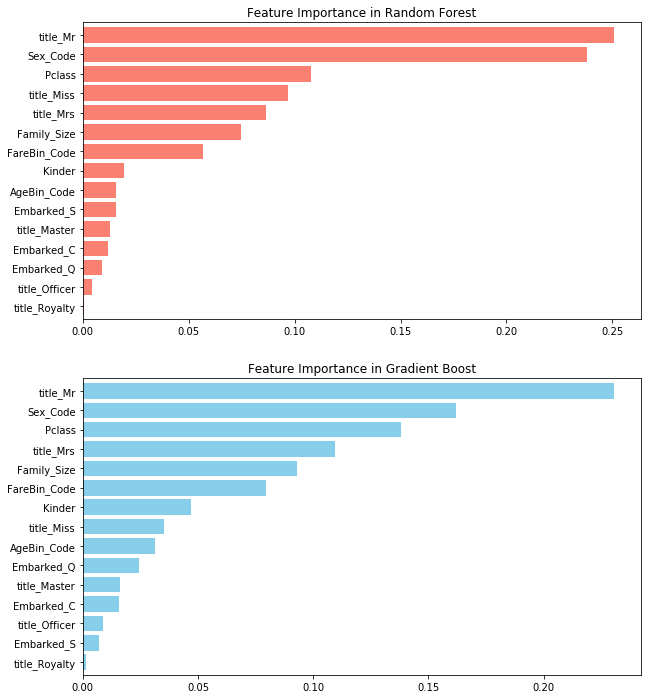

In [280]:
f,ax=plt.subplots(2,1,figsize=(10,12))
pd.Series(rf_features ,df_train.drop('Survived', axis=1).columns.values).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0], color='salmon')
ax[0].set_title('Feature Importance in Random Forest')
pd.Series(gb_features ,df_train.drop('Survived', axis=1).columns.values).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1], color = 'skyblue')
ax[1].set_title('Feature Importance in Gradient Boost')
plt.show()

In [ ]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
    'Gradient Boost feature importances': gb_features
    })

<a id = 'ch5'></a>
## 5. Second-Level Predictions from the First-level Output

<a id = 'ch5.1'></a>
## 5.1 First-level output as new features

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'SVC': svc_oof_train.ravel(),
     'Logistic': lg_oof_train.ravel(),
     'Gaussian' : NB_oof_train.ravel(),
     'Gradient_Bo' : gb_oof_train.ravel()
                                    
    })
base_predictions_train.head()

In [ ]:
base_predictions_test = pd.DataFrame( {'RandomForest': rf_oof_test.ravel(),
     'SVC': svc_oof_test.ravel(),
     'Logistic': lg_oof_test.ravel(),
     'Gaussian' : NB_oof_test.ravel(),
     'Gradient_Bo' : gb_oof_test.ravel()
                                    
    })

<a id = 'ch5.2'></a>
## 5.2 Correlation Heatmap of the Second Level Training set

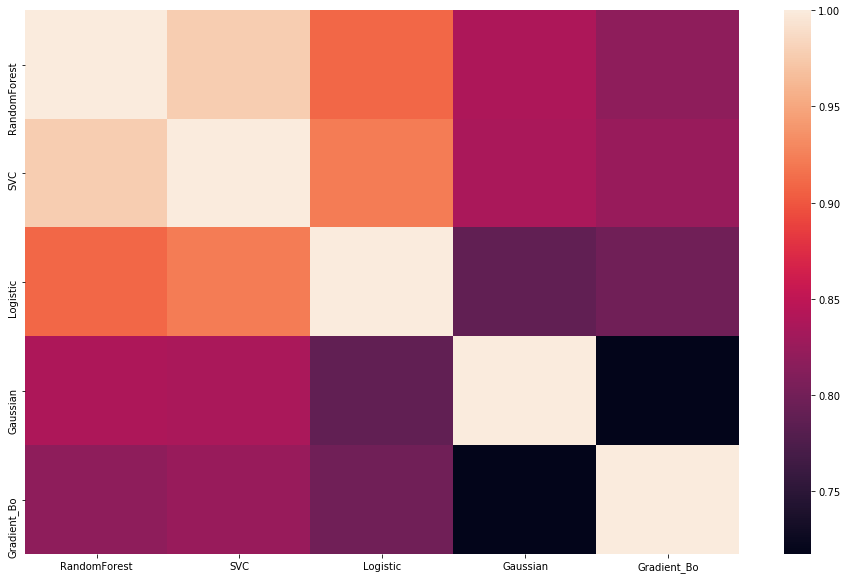

In [290]:
#plotly heatmap 
#data = [
#     go.Heatmap(
#         z= base_predictions_train.astype(float).corr().values ,
#         x=base_predictions_train.columns.values,
#         y= base_predictions_train.columns.values,
#dd         colorscale='Viridis',
#             showscale=True, 
#             reversescale = True # scale color 뒤집기
#     )
# ]
# py.iplot(data, filename='labelled-heatmap')
plt.figure(figsize=(16, 10))
sns.heatmap(base_predictions_train.astype(float).corr())
plt.show()

서로 상관성이 낮은 학습된 모델을 가지는것이 더 좋은 score를 생산한다.!

<a id = 'ch5.3'></a>
## 5.3 XGBoost를 이용한 두번째 level의 학습 모델(XGB Parameter tuning과정 포함) 
이제 첫번째 수준의 train과 test 예측을 x_train 과 x_test로 연결시키고 결합 했으므로 두 번째 수준의 학습 모델을 적용 할 수 있습니다.  
두 번째 level에서는 XGBoost를 사용할 것이고 parameter tuning과정은 아래의 kernel을 참고 하였습니다.  
https://www.kaggle.com/lifesailor/xgboost << XGBoost parameter tuning

**일반적인 Hyperparameter 튜닝 방법**

1. high learning rate(0.05 - 0.3)를 선택하고 이 학습률에 맞는 tree 개수를 선정한다.
2. tree-specific parameter를 수정한다.
    - max_depth, min_child_weight, gamma, subsample, colsample_bytree
3. regularization parameter를 수정한다.
4. 학습률을 낮추고 다시 반복한다.

**Learning rate와  estimator 수를 고정한다.**

초기값은 다음과 같이 선정한다.

1. max_depth = 5: 보통 4-6 를 시작점으로 한다.

2. min_child_weight = 1 : 향후에 튜닝할 것이다.

3. gamma = 0 :  0.1 - 0.2로 시작해도 된다. 그런데 어짜피 튜닝할 것이다.

4. subsample, colsample_bytree = 0.8 : 보통 0.5 - 0.9로 시작한다.

5. scale_pos_weight = 1: Because of high class imbalance.


In [ ]:
from sklearn.model_selection import GridSearchCV 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions

In [ ]:
# making data set for Second level prediction
x_train = np.concatenate(( lg_oof_train, rf_oof_train, NB_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( lg_oof_test, rf_oof_test, NB_oof_test, gb_oof_test, svc_oof_test), axis=1)

### 예측 모델 함수 생성

In [ ]:
#set n_estimator
def modelfit(alg, x_train, y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
   # "alg : model"
    
    # get new n_estimator
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        #xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtrain = xgb.DMatrix(x_train, label=y_train) # numpy.array
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='error', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg)
    
    # Fit the algorithm on the data
    alg.fit(x_train, y_train, eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Training Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))

In [ ]:
#기본 XGBoost
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2018
)
modelfit(xgb1, x_train, y_train)

### max_depth와 min_child_weight를 튜닝한다  
max_depth : 3 , min_child_weight :1

In [ ]:
# param_test1 = {
#  'max_depth':range(3,8,1),
#  'min_child_weight':range(1,6,1)
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
#                                                   n_estimators=1000, 
#                                                   max_depth=5, 
#                                                   min_child_weight=1, 
#                                                   gamma=0, 
#                                                   subsample=0.8, 
#                                                   colsample_bytree=0.8,
#                                                   objective= 'binary:logistic', 
#                                                   nthread=4, 
#                                                   scale_pos_weight=1, 
#                                                   seed=2019),
#                         param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=5, verbose=10)
# gsearch1.fit(x_train,y_train)
# gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


### Gamma를 튜닝한다.
gamma = 0.1

In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)] # 0~0.5 
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learnaing_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=3,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  seed=2019), 
                        param_grid = param_test2, scoring='accuracy', n_jobs=-1, iid=False, cv=5)
gsearch2.fit(x_train,y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

### subsample and colsample_bytree를 튜닝한다.
subsample : 0.6 & colsample_bytree : 0.8

In [ ]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=3,
                                                  min_child_weight=1, 
                                                  gamma=0.1, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  seed=2019), 
                        param_grid = param_test3, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch3.fit(x_train,y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

### subsample 추가 튜닝하기
subsamp : 0.6

In [ ]:
param_test4 = {
 'subsample':[i/100.0 for i in range(40,80)],
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=3,
                                                  min_child_weight=1, 
                                                  gamma=0.1, 
                                                 subsample=0.6, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  seed=2019), 
                        param_grid = param_test4, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch4.fit(x_train,y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

### reg_alpha 튜닝하기

In [ ]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=3,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.6, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  seed=2019), 
                        param_grid = param_test5, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch5.fit(x_train,y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

### learning rate 감소 시켜서 n_estimator 다시 구하기(0.1 -> 0.01)

 ## seed별 앙상블 후 결과 제출

In [ ]:
sample_submission = pd.read_csv('../input/gender_submission.csv')
seeds = [2015, 2016, 2017, 2018, 2019]

for seed in seeds:
    xgb1 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=9,
        max_depth=3,
        min_child_weight=1,
        gamma=0.1,
        reg_alpha=1e-05,
        subsample=0.6,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=seed
    )
    modelfit(xgb1, x_train, y_train)
    sample_submission['Survived'] += xgb1.predict(x_test)

<a id = 'ch6'></a>
# 6. Final Submission

In [ ]:
sample_submission['Survived'] = sample_submission['Survived'] > 2.5
sample_submission['Survived'] = sample_submission['Survived'].apply(lambda x: int(x))
sample_submission.to_csv('Final_submission.csv', index=False)